## How to Use Deep Learning, PyTorch Lightning, and the Planetary Computer to Predict Cloud Cover in Satellite Imagery

<figure><center><img src="https://drivendata-public-assets.s3.amazonaws.com/clouds-use-volcano.jpeg" width="350" height="40"></center></figure>

<p><center><i>Sentinel-2 satellite imagery being used to track a volcano eruption on La Palma, Spain. Credit: <a href="https://news.sky.com/story/la-palma-volcano-new-satellite-images-show-violent-eruption-from-space-as-lava-flows-across-island-12431412">Sky News</a></i></center></p>

Welcome to the benchmark notebook for the On Cloud N: Cloud Cover Detection Challenge! If you are just getting started, check out competition [homepage](https://www.drivendata.org/competitions/83/cloud-cover/page/396/). The goal of this benchmark is to:

1. Demonstrate how to explore and work with the data
2. Provide a basic framework for building a model
3. Demonstrate how to package your work correctly for submission

This notebook is a version of the benchmark [blog post](https://www.drivendata.co/blog/cloud-cover-benchmark/) posted on the competition website, with some small tweaks to run directly in the planetary computer hub.

You can either expand on and improve this benchmark, or start with something completely different! Let's get started.

<hr>

Satellite imagery is critical for a wide variety of applications from disaster management and recovery, to agriculture, to military intelligence. Clouds present a major obstacle for all of these use cases, and usually have to be identified and removed from a dataset before satellite imagery can be used. Improving methods of identifying clouds can unlock the potential of an unlimited range of satellite imagery use cases, enabling faster, more efficient, and more accurate image-based research.

**In this challenge, your goal is to detect cloud cover in satellite imagery**. 

The challenge uses publicly available satellite data from the [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2), which captures wide-swath, high-resolution, multi-spectral imaging. For each tile, data is separated into 13 spectral bands capturing the full visible spectrum, near-infrared, and infrared light. Feature data is shared through Microsoft's [Planetary Computer](https://planetarycomputer.microsoft.com/).

The ground truth labels for cloud cover are part of a new dataset created by [Radiant Earth Foundation](https://www.radiant.earth/). After the competition ends, the labels dataset will be made publicly available to contribute to ongoing learning and advancement in the field.

In this post, we'll cover:

- [Exploring the data](#explore-the-data)
- [Preparing the data](#split-data)
- [Following the code execution submission format](#code-exec)
- [Building the benchmark model](#build-model)
- [Fitting the benchmark model](#fit-model)
- [Generating a code execution submission](#generate-submission)

In [43]:
%%capture
!pip install pandas_path pytorch_lightning cloudpathlib loguru typer wandb nb_black typing beautifulsoup4

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# load extension for automatic formatting
%load_ext lab_black

import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path  # noqa
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import torch
import wandb
from pytorch_lightning.loggers import WandbLogger

# additional bands imports
import os
import requests
from tqdm import tqdm
from typing import Optional, List
from bs4 import BeautifulSoup

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [46]:
wandb.login()
wandb_logger = WandbLogger(project="Unet")

<a id="explore-the-data"></a>

### Explore the data

Competition data is already available within the Planetary Computer Hub in a read-only attached volume. It can be accessed at `/driven-data/cloud-cover`.

If you are working outside of the Hub, you'll need to download the data to a local folder per the instructions on the competition's data download [page](https://www.drivendata.org/competitions/83/cloud-cover/data/). You'll need to join the competition in order to view the data page. 

Data directory contents:
```
.
├── train_features
│   ├── train_chip_id_1
│   │   ├── B02.tif
│   │   ├── B03.tif
│   │   ├── B04.tif
│   │   └── B08.tif
│   └── ... 
├── train_metadata.csv
└── train_labels
    ├── train_chip_id_1.tif
    └── ... 
```


In [47]:
DATA_DIR = Path("/driven-data/cloud-cover")
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

The training data consists of 11,748 "chips". Each chip is imagery of a specific area captured at a specific point in time. There are four images associated with each chip in the competition data. Each image within a chip captures light from a different range of wavelengths, or "band". For example, the B02 band for each chip shows the strengh of visible blue light, which has a wavelength around 492 nanometers (nm). The bands provided are:


<table border="1" class="table" style="width:70%; margin-left:auto; margin-right:auto">
  <thead>
    <tr style="text-align: right;">
      <th>Band</th>
      <th>Description</th>
      <th>Center wavelength</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>B02</td>
      <td>Blue visible light</td>
      <td>497 nm</td>
    </tr>
    <tr>
      <td>B03</td>
      <td>Green visible light</td>
      <td>560 nm</td>
    </tr>
    <tr>
      <td>B04</td>
      <td>Red visible light</td>
      <td>665 nm</td>
    </tr>
    <tr>
      <td>B08</td>
      <td>Near infrared light</td>
      <td>835 nm</td>
    </tr>
  </tbody>
</table>

Let's set a global variable with the list of bands in our training data, so it's easier to iterate over them for future steps.

In [48]:
BANDS = ["B02", "B03", "B04", "B08"]

#### Metadata

Let's start by looking at the metadata for the train and test sets, to understand what the images in this competition capture.

In [49]:
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [50]:
# how many different chip ids, locations, and datetimes are there?
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

We have one row per chip, and each `chip_id` is unique. There are columns for:

- `location`: General location of the chip

- `datetime`: Date and time the satellite image was captured

- `cloudpath`: All of the satellite images for this competition are hosted on Azure Blob Storage containers. You can use this `cloudpath`, combined with the provided `download_data.py` script, to download any single chip from the container using the [cloudpathlib](https://cloudpathlib.drivendata.org/stable/) library. You can also download all of the data at once, rather than chip by chip. See the `data_download_instructions.txt` file attached to the Data Download [page](https://www.drivendata.org/competitions/83/cloud-cover/data/) for details.

Let's take a look at the distribution of chips by location.

In [51]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

In [52]:
# let's take the bottom 3916 chips in the train_location_counts so we always have validation on unseen data
# let's sort the data by location
train_meta["C"] = train_meta.groupby("location")["location"].cumcount()
train_meta.sort_values(by=["C", "location"], ascending=False, inplace=True)
train_meta
train_meta.drop("C", axis=1, inplace=True)
train_meta
# we now have most chips per location at the top and least chips per location at bottom

,chip_id,location,datetime,cloudpath
1747,cwht,Chifunfu,2020-04-24T08:20:39Z,az://./train_features/cwht
1746,cwhn,Chifunfu,2020-04-24T08:20:39Z,az://./train_features/cwhn
1745,cwhm,Chifunfu,2020-04-24T08:20:39Z,az://./train_features/cwhm
1744,cwha,Chifunfu,2020-04-24T08:20:39Z,az://./train_features/cwha
1743,cwgw,Chifunfu,2020-04-24T08:20:39Z,az://./train_features/cwgw
...,...,...,...,...
1427,cmpx,Alto Hama,2020-04-02T09:23:54Z,az://./train_features/cmpx
3037,gfrk,Alexander Bay,2020-09-05T08:58:43Z,az://./train_features/gfrk
3576,huri,Adi Ramets,2020-09-03T08:06:14Z,az://./train_features/huri
987,bvfe,Adelaide,2020-09-11T00:56:48Z,az://./train_features/bvfe


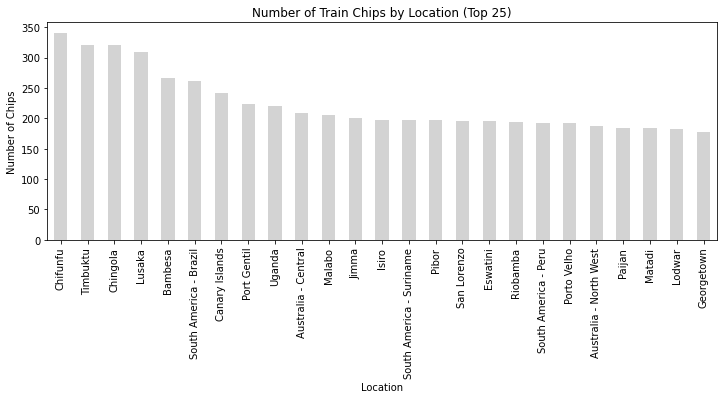

In [53]:
plt.figure(figsize=(12, 4))
train_location_counts.head(25).plot(kind="bar", color="lightgray")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Train Chips by Location (Top 25)")
plt.show()

The train and test images are from all over the world! Location names can be countries (eg. Eswatini), cities (eg. Lusaka), or broader regions of a country (eg. Australia - Central). [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2/observation-scenario) flies over the part of the Earth between 56° South and 82.8° North, between Cape Horn and slightly north of Greenland, so our observations are all between these two latitudes. The chips are mostly in Africa and South America, with some in Australia too.

We also have a timestamp for each chip. What is the time range in the data?

In [54]:
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])
train_meta["year"] = train_meta.datetime.dt.year
train_meta.groupby("year")[["chip_id"]].nunique().sort_index().rename(
    columns={"chip_id": "chip_count"}
)

,chip_count
year,
2018,326
2019,1015
2020,10407


In [55]:
train_meta["datetime"].min(), train_meta["datetime"].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [56]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


All of the images in the data were captured between February of 2018 and September of 2020. We can also see from the training data that many chips share the same location and time. 

We know from the [problem description](https://www.drivendata.org/competitions/83/cloud-cover/page/398/#metadata) that all of the locations in the test set are new, and there is no overlap between locations in the train set and the test set.

#### Images

Next, let's explore the actual satellite images - the star of the show for this challenge!

For convenience, let's first add the paths to all of the feature images per chip. Remember, the folder for each chip has four images, each of which corresponds to a different band of light wavelengths.

In [57]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
1747,cwht,Chifunfu,2020-04-24 08:20:39+00:00,az://./train_features/cwht,2020,/driven-data/cloud-cover/train_features/cwht/B...,/driven-data/cloud-cover/train_features/cwht/B...,/driven-data/cloud-cover/train_features/cwht/B...,/driven-data/cloud-cover/train_features/cwht/B...,/driven-data/cloud-cover/train_labels/cwht.tif
1746,cwhn,Chifunfu,2020-04-24 08:20:39+00:00,az://./train_features/cwhn,2020,/driven-data/cloud-cover/train_features/cwhn/B...,/driven-data/cloud-cover/train_features/cwhn/B...,/driven-data/cloud-cover/train_features/cwhn/B...,/driven-data/cloud-cover/train_features/cwhn/B...,/driven-data/cloud-cover/train_labels/cwhn.tif
1745,cwhm,Chifunfu,2020-04-24 08:20:39+00:00,az://./train_features/cwhm,2020,/driven-data/cloud-cover/train_features/cwhm/B...,/driven-data/cloud-cover/train_features/cwhm/B...,/driven-data/cloud-cover/train_features/cwhm/B...,/driven-data/cloud-cover/train_features/cwhm/B...,/driven-data/cloud-cover/train_labels/cwhm.tif
1744,cwha,Chifunfu,2020-04-24 08:20:39+00:00,az://./train_features/cwha,2020,/driven-data/cloud-cover/train_features/cwha/B...,/driven-data/cloud-cover/train_features/cwha/B...,/driven-data/cloud-cover/train_features/cwha/B...,/driven-data/cloud-cover/train_features/cwha/B...,/driven-data/cloud-cover/train_labels/cwha.tif
1743,cwgw,Chifunfu,2020-04-24 08:20:39+00:00,az://./train_features/cwgw,2020,/driven-data/cloud-cover/train_features/cwgw/B...,/driven-data/cloud-cover/train_features/cwgw/B...,/driven-data/cloud-cover/train_features/cwgw/B...,/driven-data/cloud-cover/train_features/cwgw/B...,/driven-data/cloud-cover/train_labels/cwgw.tif


Each image is a *GeoTIFF*, a raster image file that contains geographic metadata. This metadata can include coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package [rasterio](https://rasterio.readthedocs.io/en/latest/) makes it easy to interact with our geospatial raster data.

Lets look at the red visible band (B04) image for a random chip.

In [58]:
import rasterio

In [59]:
example_chip = train_meta[train_meta["chip_id"] == "pbyl"].iloc[0]

example_chip

chip_id                                                    pbyl
location                                                 Lodwar
datetime                              2020-09-08 08:09:15+00:00
cloudpath                            az://./train_features/pbyl
year                                                       2020
B02_path      /driven-data/cloud-cover/train_features/pbyl/B...
B03_path      /driven-data/cloud-cover/train_features/pbyl/B...
B04_path      /driven-data/cloud-cover/train_features/pbyl/B...
B08_path      /driven-data/cloud-cover/train_features/pbyl/B...
label_path       /driven-data/cloud-cover/train_labels/pbyl.tif
Name: 6571, dtype: object

The example chip is an image taken from Lodwar, a northwestern town in Kenya.

In [60]:
with rasterio.open(example_chip["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 771935.0,
        0.0, -10.0, 331300.0)}

We can see that the features are single-band images, with a shape of 512 x 512. The pixel values for each image measure the strength of light reflected back to the satellite for the specific set of wavelengths in that band. The array below shows the strength of red visible light, with wavelengts around 665 nm.

We can also see that there are no missing values in the image. This should be the case for all of the provided competition feature data.

In [61]:
# what does the image array look like?
print("Image array shape:", img_array.shape)
img_array

Image array shape: (512, 512)


array([[ 519,  532,  556, ..., 3662, 3564, 3544],
       [ 549,  539,  562, ..., 3604, 3520, 3518],
       [ 572,  524,  506, ..., 3514, 3488, 3518],
       ...,
       [1216, 2062, 2898, ..., 4050, 3610, 3328],
       [1632, 1932, 2588, ..., 4108, 3918, 3736],
       [1766, 2040, 2272, ..., 4152, 4028, 3824]], dtype=uint16)

In [62]:
np.isnan(img_array).sum()

0

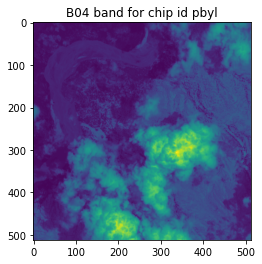

In [63]:
plt.imshow(img_array)
plt.title(f"B04 band for chip id {example_chip.chip_id}")
plt.show()

#### Coordinates

Using the metadata returned by `rasterio`, we can also get longitude and latitude coordinates.

In [64]:
# longitude/latitude of image's center
with rasterio.open(example_chip["B04_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

Longitude: 35.46935026347422, latitude: 2.9714117132510944


In [65]:
bounds

BoundingBox(left=771935.0, bottom=326180.0, right=777055.0, top=331300.0)

We have the longitude and latitude of the center of the image, but the bounding box values look very different. That's because the bounding box is given in whatever coordinate reference system the image is projected in, rather than traditional longitude and latiude. We can see which system with the `crs` value from the metadata.

We can convert the bounding box to longitude and latitude using `pyproj`.

In [66]:
import pyproj

In [67]:
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)

In [68]:
left, bottom, right, top = lat_long_bounds(example_chip["B04_path"])
print(
    f"Image coordinates (lat, long):\nStart: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long):
Start: (2.948221298028172, 35.44628398518643)
End: (2.9946024439490517, 35.492417498478574)


#### True color image

We can make a composite image from the three visible bands (blue, green, and red) to visualize a high-quality, true color image. To show the true color image, we'll use the `rioxarray` and `xrspatial` packages designed for Sentinel-2 satellite data.

In [69]:
import rioxarray
import xrspatial.multispectral as ms

In [70]:
def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = data_dir / chip_id
    red = rioxarray.open_rasterio(chip_dir / "B04.tif").squeeze()
    green = rioxarray.open_rasterio(chip_dir / "B03.tif").squeeze()
    blue = rioxarray.open_rasterio(chip_dir / "B02.tif").squeeze()

    return ms.true_color(r=red, g=green, b=blue)

Text(0.5, 1.0, 'True color image for chip id pbyl')

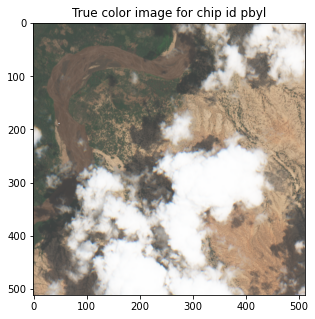

In [71]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {example_chip.chip_id}")

That's a pretty high quality image!

Let's look at a few random training chips and their cloud labels.

In [72]:
def display_random_chip(random_state):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]

    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = Image.open(random_chip.label_path)
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {random_chip.chip_id} label")

    plt.tight_layout()
    plt.show()

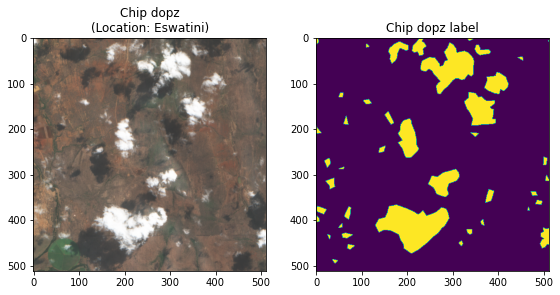

In [73]:
display_random_chip(1)

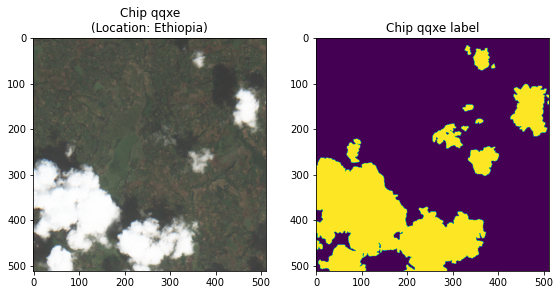

In [74]:
display_random_chip(9)

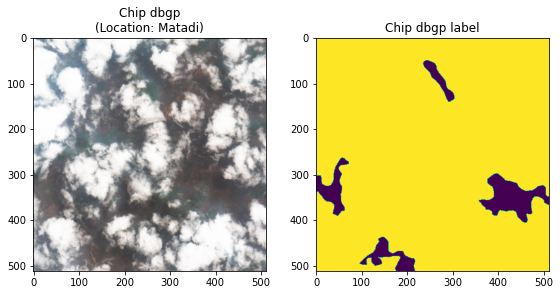

In [75]:
display_random_chip(40)

From the example chips, we can see that there is a very big variation in the amount of cloud cover per chip. The chip from Riobamba, Ecuador is almost completely obscured by clouds, while the chip from Macapá, Brazil has almost none.

<a id='split-data'></a>

### Split the data

To train our model, we want to separate the data into a "training" set and a "validation" set. That way we'll have a portion of labelled data that was not used in model training, which can give us a more accurate sense of how our model will perform on the competition test data. Remember, none of the test set locations are in competition training data, so your model's will performance will ultimately be measured on unseen locations.

We have chosen the simplest route, and split our training chips randomly into 1/3 validation and 2/3 training. You may want to think about splitting by location instead of by chip, to better check how your model will do in new settings.

In [76]:
import random

In [77]:
"""random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape
"""

'random.seed(9)  # set a seed for reproducibility\n\n# put 1/3 of chips into the validation set\nchip_ids = train_meta.chip_id.unique().tolist()\nval_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))\n\nval_mask = train_meta.chip_id.isin(val_chip_ids)\nval = train_meta[val_mask].copy().reset_index(drop=True)\ntrain = train_meta[~val_mask].copy().reset_index(drop=True)\n\nval.shape, train.shape\n'

In [78]:
train = train_meta[:-3877].reset_index(drop=True)
val = train_meta[-3877:].reset_index(drop=True)
val

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,fmzh,Canary Islands,2020-09-02 11:53:46+00:00,az://./train_features/fmzh,2020,/driven-data/cloud-cover/train_features/fmzh/B...,/driven-data/cloud-cover/train_features/fmzh/B...,/driven-data/cloud-cover/train_features/fmzh/B...,/driven-data/cloud-cover/train_features/fmzh/B...,/driven-data/cloud-cover/train_labels/fmzh.tif
1,qjlf,Cabo Verdo,2018-11-08 12:17:04+00:00,az://./train_features/qjlf,2018,/driven-data/cloud-cover/train_features/qjlf/B...,/driven-data/cloud-cover/train_features/qjlf/B...,/driven-data/cloud-cover/train_features/qjlf/B...,/driven-data/cloud-cover/train_features/qjlf/B...,/driven-data/cloud-cover/train_labels/qjlf.tif
2,lpou,Bunbury,2020-08-29 02:27:00+00:00,az://./train_features/lpou,2020,/driven-data/cloud-cover/train_features/lpou/B...,/driven-data/cloud-cover/train_features/lpou/B...,/driven-data/cloud-cover/train_features/lpou/B...,/driven-data/cloud-cover/train_features/lpou/B...,/driven-data/cloud-cover/train_labels/lpou.tif
3,wzbx,Bor,2020-09-14 08:28:34+00:00,az://./train_features/wzbx,2020,/driven-data/cloud-cover/train_features/wzbx/B...,/driven-data/cloud-cover/train_features/wzbx/B...,/driven-data/cloud-cover/train_features/wzbx/B...,/driven-data/cloud-cover/train_features/wzbx/B...,/driven-data/cloud-cover/train_labels/wzbx.tif
4,vwsf,Beira,2020-09-12 07:55:45+00:00,az://./train_features/vwsf,2020,/driven-data/cloud-cover/train_features/vwsf/B...,/driven-data/cloud-cover/train_features/vwsf/B...,/driven-data/cloud-cover/train_features/vwsf/B...,/driven-data/cloud-cover/train_features/vwsf/B...,/driven-data/cloud-cover/train_labels/vwsf.tif
...,...,...,...,...,...,...,...,...,...,...
3872,cmpx,Alto Hama,2020-04-02 09:23:54+00:00,az://./train_features/cmpx,2020,/driven-data/cloud-cover/train_features/cmpx/B...,/driven-data/cloud-cover/train_features/cmpx/B...,/driven-data/cloud-cover/train_features/cmpx/B...,/driven-data/cloud-cover/train_features/cmpx/B...,/driven-data/cloud-cover/train_labels/cmpx.tif
3873,gfrk,Alexander Bay,2020-09-05 08:58:43+00:00,az://./train_features/gfrk,2020,/driven-data/cloud-cover/train_features/gfrk/B...,/driven-data/cloud-cover/train_features/gfrk/B...,/driven-data/cloud-cover/train_features/gfrk/B...,/driven-data/cloud-cover/train_features/gfrk/B...,/driven-data/cloud-cover/train_labels/gfrk.tif
3874,huri,Adi Ramets,2020-09-03 08:06:14+00:00,az://./train_features/huri,2020,/driven-data/cloud-cover/train_features/huri/B...,/driven-data/cloud-cover/train_features/huri/B...,/driven-data/cloud-cover/train_features/huri/B...,/driven-data/cloud-cover/train_features/huri/B...,/driven-data/cloud-cover/train_labels/huri.tif
3875,bvfe,Adelaide,2020-09-11 00:56:48+00:00,az://./train_features/bvfe,2020,/driven-data/cloud-cover/train_features/bvfe/B...,/driven-data/cloud-cover/train_features/bvfe/B...,/driven-data/cloud-cover/train_features/bvfe/B...,/driven-data/cloud-cover/train_features/bvfe/B...,/driven-data/cloud-cover/train_labels/bvfe.tif


In [79]:
# separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS] + ["datetime"]

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

In [80]:
val_x.head()

,chip_id,B02_path,B03_path,B04_path,B08_path,datetime
0,fmzh,/driven-data/cloud-cover/train_features/fmzh/B...,/driven-data/cloud-cover/train_features/fmzh/B...,/driven-data/cloud-cover/train_features/fmzh/B...,/driven-data/cloud-cover/train_features/fmzh/B...,2020-09-02 11:53:46+00:00
1,qjlf,/driven-data/cloud-cover/train_features/qjlf/B...,/driven-data/cloud-cover/train_features/qjlf/B...,/driven-data/cloud-cover/train_features/qjlf/B...,/driven-data/cloud-cover/train_features/qjlf/B...,2018-11-08 12:17:04+00:00
2,lpou,/driven-data/cloud-cover/train_features/lpou/B...,/driven-data/cloud-cover/train_features/lpou/B...,/driven-data/cloud-cover/train_features/lpou/B...,/driven-data/cloud-cover/train_features/lpou/B...,2020-08-29 02:27:00+00:00
3,wzbx,/driven-data/cloud-cover/train_features/wzbx/B...,/driven-data/cloud-cover/train_features/wzbx/B...,/driven-data/cloud-cover/train_features/wzbx/B...,/driven-data/cloud-cover/train_features/wzbx/B...,2020-09-14 08:28:34+00:00
4,vwsf,/driven-data/cloud-cover/train_features/vwsf/B...,/driven-data/cloud-cover/train_features/vwsf/B...,/driven-data/cloud-cover/train_features/vwsf/B...,/driven-data/cloud-cover/train_features/vwsf/B...,2020-09-12 07:55:45+00:00


In [81]:
val_y.head()

,chip_id,label_path
0,fmzh,/driven-data/cloud-cover/train_labels/fmzh.tif
1,qjlf,/driven-data/cloud-cover/train_labels/qjlf.tif
2,lpou,/driven-data/cloud-cover/train_labels/lpou.tif
3,wzbx,/driven-data/cloud-cover/train_labels/wzbx.tif
4,vwsf,/driven-data/cloud-cover/train_labels/vwsf.tif


<a id='code-exec'></a>

### Code Execution Format


<div class="alert alert-info">
<strong>This is a code submission challenge! Rather than submitting your predicted labels, you'll package everything needed to do inference and submit that for containerized execution.</strong> The <a href="https://github.com/drivendataorg/cloud-cover-runtime">runtime repository</a> contains the complete specification for the runtime. See the Code Submission Format <a href="https://www.drivendata.org/competitions/83/cloud-cover/page/412/">page</a> for full details. You can learn more about how our code execution competitions work <a href="https://www.drivendata.co/blog/code-execution-competitions/">here</a>.
</div>

Rather than just generating predictions, this benchmark will show you how to create a correct submission for code execution. Your final submission will be a zipped archive called `submission.zip`. We'll create a folder called `benchmark_src`, and develop a complete code execution submission in that folder. `benchmark_src` will ultimately include:

1. The weights for our trained model

2. A `main.py` script that loads the model, performs inference on images stored in `data/test_features`, generates chip-level predictions, and saves them out to `predictions/`. File names should match the chip IDs from the test dataset. For example, if the test set includes a chip with ID `abcd`, running `main.py` must write out a predicted cloud cover TIF mask to `predictions/abcd.tif`. The predictions should be .tifs with values of `1` and `0` indicating cloud or no cloud.

3. Any additional scripts that `main.py` needs in order to run

`main.py` must be able to run without getting any input arguments, so make sure you set all your defaults so that calling `python main.py` alone runs the full process. **Your final submission should *not* include prediction files.**

All of the key code for inference is written out to scripts in `benchmark_src` using the line magic `%%file` instead of being run directly in this notebook. The final scripts that are written out by this notebook are also saved in a folder of the [runtime repo](https://github.com/drivendataorg/cloud-cover-runtime/tree/main/benchmark_src).

In [82]:
# create benchmark_src folder
submission_dir = Path("benchmark_src")
if submission_dir.exists():
    shutil.rmtree(submission_dir)

submission_dir.mkdir(parents=True)

We'll run inference in this notebook by importing classes and functions from the scripts in `benchmark_src`.

<a id="build-model"></a>

### Build the model

As a starting point, we'll build a basic neural network model using some of the standard libraries. That way there's lots of room for you to make improvements!

We'll use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/), a package that introduces useful conventions for training deep learning models on top of PyTorch. Our model will start with a publicly available [convolutional neural network](https://www.youtube.com/watch?v=aircAruvnKk&t=995s) called [U-Net](https://arxiv.org/abs/1505.04597) that is pretrained for [semantic segmentation](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47).

**U-Net** was first designed to help process biomedical imaging and identify things like signs of disease. The basic structure is an encoder network followed by a decoder network. We'll use a pretrained backbone called [ResNet34](https://arxiv.org/abs/1512.03385) as our encoder.

#### `CloudDataset`

The first step of building the model is actually writing a class that will tell the model how to handle our feature data. Thankfully, the PyTorch `Dataset` and `DataLoader` classes take care of most of this for us! A `Dataset` object allows us to define custom methods for working with the data, and a `DataLoader` object parallelizes data loading. If you haven't worked with these classes before, we highly recommend this short [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

We'll write a custom dataset called `CloudDataset` that reads our satellite image training data into memory, converts the data to PyTorch tensors, and serves the data to our model in batches. Our class will inherit from `torch.utils.data.Dataset`, and [override](https://www.tutorialspoint.com/overriding-methods-in-python) a few key methods:

`__len__()`: return the number of chips in the dataset

`__getitem__()`: return a sample from the dataset as a dictionary, with keys for:
- `chip_id`: unique identifiers for each chip

- `chip`: the image array of the chip, with all four provided bands combined. The shape of each image array will be (4, 512, 512). 

- `label`: the label tif mask, if it exists

In [83]:
%%file {submission_dir}/cloud_dataset.py
import numpy as np
import pandas as pd
import rasterio
import torch
from typing import Optional, List

#extra bands

from datetime import datetime, timedelta
from typing import Dict, Optional, Sequence, Tuple, Union

from loguru import logger
import numpy as np
import pandas as pd

from PIL import Image
import planetary_computer as pc
from pystac_client import Client
import shapely.geometry
import rasterio
import requests
import rioxarray

from bs4 import BeautifulSoup

DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%SZ"


catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
collection = catalog.get_collection("sentinel-2-l2a")


def get_closest_item(
    items: Sequence[dict],
    polygon: shapely.geometry.polygon.Polygon,
    timestamp: datetime,
) -> Optional[dict]:
    """
    Returns the item with maximum overlap and closest timestamp.

    Args:
        items (Sequence[dict]): items returned by a PySTAC catalog search
        polygon (shapely.geometry.polygon.Poylgon): polygon of the latitude/longitude
            coordinates for the original chip to be matched
        timestamp (datetime.timestamp): timestamp for the original chip to be matched

    Returns:
        pystac.item.Item: PySTAC item with the closest timestamp and/or maximum
            geographic overlap to the original chip to be matched.
    """
    if len(items) == 1:
        return items[0]

    # Check for exactly matching timestamp (to the minute) with sensing_time
    sensing_times = []
    for item in items:
        granule_metadata_href = pc.sign(item.assets["granule-metadata"].href)
        granule_metadata = requests.get(granule_metadata_href)
        soup = BeautifulSoup(granule_metadata.text)
        sensing_times.append(
            pd.to_datetime(soup.find("sensing_time").text).round(freq="T")
        )
    exact_timestamp_matches = [
        item
        for item, sensing_time in zip(items, sensing_times)
        if sensing_time == pd.to_datetime(timestamp).round(freq="T")
    ]

    # If only one item has a perfect match, return it
    if len(exact_timestamp_matches) == 1:
        return exact_timestamp_matches[0]

    # Compute overlap between each query result and the geotiff polygon
    overlaps = [
        shapely.geometry.shape(item.geometry).intersection(polygon).area / polygon.area
        for item in items
    ]
    max_overlap = max(overlaps)
    items_overlaps = [
        (item, overlap)
        for item, overlap in zip(items, overlaps)
        if overlap == max_overlap
    ]

    # If one item has higher overlap than the rest, return it
    if len(items_overlaps) == 1:
        return items_overlaps[0][0]

    # If multiple have equally high overlap, return item with closest sensing_time
    max_overlap_sensing_times = [
        sensing_time
        for sensing_time, overlap in zip(sensing_times, overlaps)
        if overlap == max_overlap
    ]
    time_deltas = [
        abs(sensing_time - timestamp) for sensing_time in max_overlap_sensing_times
    ]
    return items_overlaps[np.argmin(time_deltas)][0]


def query_bands(
    geotiff: rasterio.io.DatasetReader,
    timestamp: Union[datetime, pd.Timestamp, str],
    asset_keys: Sequence[str],
    query_range_minutes: int = 120,
    output_shape: Optional[Tuple[int, int]] = None,
    verbose: Optional[bool] = True,
) -> Dict[str, np.ndarray]:
    """
    Queries the Planetary Computer STAC API for additional imagery that
    corresponds to the same spatial extent as a provided GeoTIFF.

    Args:
        geotiff (rasterio.io.DatasetReader): A rasterio GeoTIFF
        timestamp (datetime or str): Timestamp for GeoTIFF acquisition used
            in the STAC API query to find the corresponding scene
        asset_keys (sequence of str): A sequence (list, tuple, set, etc.) of
            keys specifying the desired STAC assets to return
        query_range_minutes (int): Duration of the time range for the STAC API
            query. You can increase this if the query does not return any results.
        output_shape (tuple of ints, optional): If provided, reshape the output
            to this (height, width)
        verbose (bool, Optional): Whether to print logging messages. Defaults to True

    Returns:
        dict {str: np.ndarray}: A dictionary where each key is an asset name, and each value
            is the array of values for that asset from the PySTAC item that most closely
            matches the original chip's location and time
    """
    # Convert bounds to regular lat/long coordinates
    left, bottom, right, top = rasterio.warp.transform_bounds(
        geotiff.meta["crs"],
        4326,  # code for the lat-lon coordinate system
        *geotiff.bounds,
    )

    # Get a polygon for the area to search
    area_of_interest = shapely.geometry.shape(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [left, bottom],
                    [left, top],
                    [right, top],
                    [right, bottom],
                    [left, bottom],
                ]
            ],
        }
    )

    # Get the timestamp range to search
    if isinstance(timestamp, str):
        timestamp = pd.to_datetime(timestamp)
    if isinstance(timestamp, pd.Timestamp):
        timestamp = timestamp.to_pydatetime()
    range_start = timestamp - timedelta(minutes=query_range_minutes // 2)
    range_end = timestamp + timedelta(minutes=query_range_minutes // 2)
    time_range = (
        f"{range_start.strftime(DATETIME_FORMAT)}/{range_end.strftime(DATETIME_FORMAT)}"
    )

    # Search the Sentinel-2 catalog
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=area_of_interest,
        datetime=time_range,
    )

    # Filter to the best-matching item
    items = list(search.get_items())
    if len(items) == 0:
        raise ValueError(
            "Query returned no results. Check that the bounding box is correct "
            f"or try increasing the query time range. Chip: {geotiff.name}"
        )
    item = get_closest_item(items, area_of_interest, timestamp)

    # Ensure that original chip and PySTAC item have the same coordinate projection
    if geotiff.meta["crs"] == item.properties["proj:epsg"]:
        if verbose:
            logger.debug(
                f"""GeoTIFF and STAC item have same CRS {geotiff.meta["crs"]}"""
            )
        bounds = geotiff.bounds
    else:
        if verbose:
            logger.debug(
                f"""Transforming from {geotiff.meta["crs"]} """
                f"""to {item.properties["proj:epsg"]}"""
            )
        bounds = rasterio.warp.transform_bounds(
            geotiff.meta["crs"],
            item.properties["proj:epsg"],
            geotiff.bounds.left,
            geotiff.bounds.bottom,
            geotiff.bounds.right,
            geotiff.bounds.top,
        )

    # Load the matching PySTAC asset
    assets = {}
    for asset_key in asset_keys:
        asset = np.array(
            rioxarray.open_rasterio(pc.sign(item.assets[asset_key].href))
            .rio.clip_box(*bounds)
            .load()
            .transpose("y", "x", "band")
        )

        # Reshape to singe-band image and resize if needed
        asset = Image.fromarray(asset.squeeze())
        if output_shape:
            asset = asset.resize(output_shape)
        assets[asset_key] = np.array(asset)

    return assets
#end of extra bands

class CloudDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(
        self,
        x_paths: pd.DataFrame,
        bands: List[str],
        y_paths: Optional[pd.DataFrame] = None,
        transforms: Optional[list] = None,
    ):
        """
        Instantiate the CloudDataset class.

        Args:
            x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands
            bands (list[str]): list of the bands included in the data
            y_paths (pd.DataFrame, optional): a dataframe with a for each chip and columns for chip_id
                and the path to the label TIF with ground truth cloud cover
            transforms (list, optional): list of transforms to apply to the feature data (eg augmentations)
        """
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms
        self.bands = bands

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # Loads an n-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        band_arrs = []
        
         # additional band    
        wvp_assets =  query_bands(
            rasterio.open(img["B04_path"]),
            timestamp=img["datetime"],
            asset_keys=["B09"],
            query_range_minutes=240,
            output_shape=[512,512],
            verbose=True,
            )  
        # end of additional band
        
        for band in self.bands:
            with rasterio.open(img[f"{band}_path"]) as b:
                band_arr = b.read(1).astype("float32")
            band_arrs.append(band_arr)
        #new line for extra band
        band_arrs.append(wvp_assets["B09"].astype("float32"))
        
        x_arr = np.stack(band_arrs, axis=-1)

        # Apply data augmentations, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare dictionary for item
        item = {"chip_id": img.chip_id, "chip": x_arr}

        # Load label if available
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1).astype("float32")
            # Apply same data augmentations to the label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            item["label"] = y_arr

        return item

Writing benchmark_src/cloud_dataset.py


Our custom dataset does not implement any transformations or feature engineering. Applying data augmentations and transformations is a good way to train your model on a wider variety of scenarios without needing more data. The [albumentations](https://albumentations.ai/) library is a good place to start if you want to implement some of these!

#### Loss class

Next we'll set up a custom loss class for calculating intersection over union (IOU), the competition [performance metric](https://www.drivendata.org/competitions/83/cloud-cover/page/398/#performance-metric). During training, we'll define the best model as the one that gets the highest IOU on the validation set.

For our training steps, we'll minimize [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression). Cross-entropy loss broadly evaluates the differences between predicted and ground truth pixels and averages over all pixels. For this, we can use the built-in `torch.nn.CrossEntropyLoss()`.

In [84]:
%%file {submission_dir}/losses.py
import numpy as np


def intersection_over_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum() / union.sum()

Writing benchmark_src/losses.py


#### `CloudModel`

Now is the moment we've all been waiting for - coding our actual model! 

Again, we'll make our lives simpler by starting with the [`pl.LightningModule`](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html) class from Pytorch Lightning. This comes with most of the logic we need, so we only have to specify components that are specific to our modeling setup. Our custom `CloudModel` class will define:

- `__init__`: how to instantiate a `CloudModel` class

- `forward`: forward pass for an image in the neural network propogation

- `training_step`: switch the model to train mode, implement the forward pass, and calculate training loss (cross-entropy) for a batch

- `validation_step`: switch the model to eval mode and calculate validation loss (IOU) for the batch

- `train_dataloader`: call an iterable over the training dataset for automatic batching

- `val_dataloader`: call an iterable over the validation dataset for automatic batching

- `configure_optimizers`: configure an [optimizer](https://pytorch.org/docs/stable/optim.html) and a [scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html) to dynamically adjust the learning rate based on the number of epochs

- `_prepare_model`: load the U-Net model with a ResNet34 backbone from the `segmentation_models_pytorch` package

In [89]:
%%file {submission_dir}/cloud_model.py
from typing import Optional, List

import pandas as pd
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch

try:
    from cloud_dataset import CloudDataset
    from losses import intersection_over_union
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.losses import intersection_over_union


class CloudModel(pl.LightningModule):
    def __init__(
        self,
        bands: List[str],
        x_train: Optional[pd.DataFrame] = None,
        y_train: Optional[pd.DataFrame] = None,
        x_val: Optional[pd.DataFrame] = None,
        y_val: Optional[pd.DataFrame] = None,
        hparams: dict = {},
    ):
        """
        Instantiate the CloudModel class based on the pl.LightningModule
        (https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

        Args:
            bands (list[str]): Names of the bands provided for each chip
            x_train (pd.DataFrame, optional): a dataframe of the training features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_train (pd.DataFrame, optional): a dataframe of the training labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            x_val (pd.DataFrame, optional): a dataframe of the validation features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_val (pd.DataFrame, optional): a dataframe of the validation labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            hparams (dict, optional): Dictionary of additional modeling parameters.
        """
        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()

        # required
        self.bands = bands

        # optional modeling params
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.gpu = self.hparams.get("gpu", False)
        self.transform = None

        # Instantiate datasets, model, and trainer params if provided
        self.train_dataset = CloudDataset(
            x_paths=x_train,
            bands=self.bands,
            y_paths=y_train,
            transforms=self.transform,
        )
        self.val_dataset = CloudDataset(
            x_paths=x_val,
            bands=self.bands,
            y_paths=y_val,
            transforms=None,
        )
        self.model = self._prepare_model()

    ## Required LightningModule methods ##

    def forward(self, image: torch.Tensor):
        # Forward pass
        return self.model(image)

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.train_dataset.data is None:
            raise ValueError(
                "x_train and y_train must be specified when CloudModel is instantiated to run training"
            )

        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Log batch loss
        loss = torch.nn.CrossEntropyLoss(reduction="none")(preds, y).mean()
        self.log(
            "loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.val_dataset.data is None:
            raise ValueError(
                "x_val and y_val must be specified when CloudModel is instantiated to run validation"
            )

        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1  # convert to int

        # Log batch IOU
        batch_iou = intersection_over_union(preds, y)
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

    ## Convenience Methods ##

    def _prepare_model(self):
        # Instantiate U-Net model
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=5,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()

        return unet_model

Overwriting benchmark_src/cloud_model.py


In [90]:
from benchmark_src.cloud_model import CloudModel

<a id='fit-model'></a>

### Fit the model

It's go time! The only required arguments to fit the model are the train features, the train labels, the validation features, and the validation labels. 

We've opted to train with all of the defaults hyperparameters defined in `__init__` for simplicity, so there is a lot of room for tweaks and improvements! You can experiment with things like learning rate, patience, batch size, and much much more.

In [91]:
import warnings

warnings.filterwarnings("ignore")

In [92]:
# Set up pytorch_lightning.Trainer object
cloud_model = CloudModel(
    bands=BANDS,
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y,
    hparams={"num_workers": 7, "batch_size": 8},
)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="iou_epoch", mode="max", verbose=True
)
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(cloud_model.patience * 3),
    mode="max",
    verbose=True,
)

trainer = pl.Trainer(
    gpus=1,
    fast_dev_run=False,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [93]:
# Fit the model
trainer.fit(model=cloud_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


wandb: WARNING Serializing object of type DataFrame that is 3565707 bytes
wandb: WARNING Serializing object of type DataFrame that is 1235891 bytes
wandb: WARNING Serializing object of type DataFrame that is 1756425 bytes
wandb: WARNING Serializing object of type DataFrame that is 608833 bytes

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.771    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

2022-01-09 22:49:14.387 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32628
2022-01-09 22:49:15.250 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32626
2022-01-09 22:49:15.687 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32750
2022-01-09 22:49:16.962 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32636
2022-01-09 22:49:17.406 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32736
2022-01-09 22:49:17.998 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32630
2022-01-09 22:49:18.571 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32635
2022-01-09 22:49:19.030 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF

Training: 0it [00:00, ?it/s]

2022-01-09 22:49:31.939 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32722
2022-01-09 22:49:31.949 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32732
2022-01-09 22:49:31.975 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32720
2022-01-09 22:49:32.041 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32732
2022-01-09 22:49:32.042 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32628
2022-01-09 22:49:32.039 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32636


APIError: Caught APIError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/srv/conda/envs/notebook/lib/python3.8/http/client.py", line 1348, in getresponse
    response.begin()
  File "/srv/conda/envs/notebook/lib/python3.8/http/client.py", line 316, in begin
    version, status, reason = self._read_status()
  File "/srv/conda/envs/notebook/lib/python3.8/http/client.py", line 285, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconnected: Remote end closed connection without response

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/requests/adapters.py", line 439, in send
    resp = conn.urlopen(
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/connectionpool.py", line 755, in urlopen
    retries = retries.increment(
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/util/retry.py", line 532, in increment
    raise six.reraise(type(error), error, _stacktrace)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/packages/six.py", line 769, in reraise
    raise value.with_traceback(tb)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/srv/conda/envs/notebook/lib/python3.8/http/client.py", line 1348, in getresponse
    response.begin()
  File "/srv/conda/envs/notebook/lib/python3.8/http/client.py", line 316, in begin
    version, status, reason = self._read_status()
  File "/srv/conda/envs/notebook/lib/python3.8/http/client.py", line 285, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
urllib3.exceptions.ProtocolError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pystac_client/stac_api_io.py", line 134, in request
    resp = self.session.send(prepped)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/requests/sessions.py", line 655, in send
    r = adapter.send(request, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/requests/adapters.py", line 498, in send
    raise ConnectionError(err, request=request)
requests.exceptions.ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jovyan/PlanetaryComputerExamples/competitions/cloud-cover/benchmark_src/cloud_dataset.py", line 259, in __getitem__
    wvp_assets =  query_bands(
  File "/home/jovyan/PlanetaryComputerExamples/competitions/cloud-cover/benchmark_src/cloud_dataset.py", line 172, in query_bands
    items = list(search.get_items())
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pystac_client/item_search.py", line 436, in get_items
    for item_collection in self.get_item_collections():
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pystac_client/item_search.py", line 424, in get_item_collections
    for page in self._stac_io.get_pages(self.url, self.method, self.get_parameters()):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pystac_client/stac_api_io.py", line 209, in get_pages
    page = self.read_json(url, method=method, parameters=parameters)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pystac/stac_io.py", line 197, in read_json
    txt = self.read_text(source, *args, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pystac_client/stac_api_io.py", line 77, in read_text
    return self.request(href, *args, parameters=parameters, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pystac_client/stac_api_io.py", line 139, in request
    raise APIError(str(err))
pystac_client.exceptions.APIError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


2022-01-09 22:49:32.638 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32733
2022-01-09 22:49:32.654 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32736
2022-01-09 22:49:33.353 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32636
2022-01-09 22:49:33.359 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32753
2022-01-09 22:49:33.364 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32637
2022-01-09 22:49:33.380 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32630
2022-01-09 22:49:33.422 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF and STAC item have same CRS EPSG:32628
2022-01-09 22:49:33.577 | DEBUG    | benchmark_src.cloud_dataset:query_bands:183 - GeoTIFF

Our best IOU on the validation split is 0.887.

If you'd like to track changes in performance more closely, you could log information about metrics across batches, epochs, and models through the [TensorBoard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) UI.

<a id='generate-submission'></a>

### Generate a submission

Now that we have our trained model, we can generate a full submission. **Remember that this is a [code execution](https://www.drivendata.org/competitions/83/cloud-cover/page/412/) competition,** so you will be submitting our inference code rather than our predictions. We've already written out our key class definition to scripts in the folder `benchmark_src`, which now contains:

```
benchmark_src
├── cloud_dataset.py
├── cloud_model.py
└── losses.py
```

To submit to the competition, we still need to:

1. Store our trained model weights in `benchmark_src` so that they can be loaded during inference

2. Write a `main.py` file that loads our model weights, generates predictions for each chip, and saves the predictions to a folder called `predictions` in the same directory as itself

3. Zip the contents of `benchmark_src/` - not the directory itself - into a file called `submission.zip`. 

4. Upload `submission.zip` to the competition submissions page. The file will be unzipped and `main.py` will be run in a [containerized execution environment](https://github.com/drivendataorg/cloud-cover-runtime) to calculate our model's IOU.

#### 1. Save our model

First, let's make a folder for our model assets, and save the weights for our trained model using PyTorch's handy `model.save()` method. The below saves the weights to `benchmark_src/assets/cloud_model.pt`.

In [50]:
# save the model
submission_assets_dir = submission_dir / "assets"
submission_assets_dir.mkdir(parents=True, exist_ok=True)

model_weight_path = submission_assets_dir / "cloud_model.pt"
torch.save(cloud_model.state_dict(), model_weight_path)

#### 2. Write `main.py`

Now we'll write out a script called `main.py` to `benchmark_src`, which runs the whole inference process using the saved model weights.

In [51]:
%%file benchmark_src/main.py
import os
from pathlib import Path
from typing import List

from loguru import logger
import pandas as pd
from PIL import Image
import torch
import typer

try:
    from cloud_dataset import CloudDataset
    from cloud_model import CloudModel
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.cloud_model import CloudModel


ROOT_DIRECTORY = Path("/codeexecution")
PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / "predictions"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Set the pytorch cache directory and include cached models in your submission.zip
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "assets/torch")


def get_metadata(features_dir: os.PathLike, bands: List[str]):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in chip_ids:
        chip_bands = [features_dir / chip_id / f"{band}.tif" for band in bands]
        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})


def make_predictions(
    model: CloudModel,
    x_paths: pd.DataFrame,
    bands: List[str],
    predictions_dir: os.PathLike,
):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        bands (list[str]): list of bands provided for each chip
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
    test_dataset = CloudDataset(x_paths=x_paths, bands=bands)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=model.batch_size,
        num_workers=model.num_workers,
        shuffle=False,
        pin_memory=True,
    )

    for batch_index, batch in enumerate(test_dataloader):
        logger.debug(f"Predicting batch {batch_index} of {len(test_dataloader)}")
        x = batch["chip"]
        preds = model.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5).detach().numpy().astype("uint8")
        for chip_id, pred in zip(batch["chip_id"], preds):
            chip_pred_path = predictions_dir / f"{chip_id}.tif"
            chip_pred_im = Image.fromarray(pred)
            chip_pred_im.save(chip_pred_path)


def main(
    model_weights_path: Path = ASSETS_DIRECTORY / "cloud_model.pt",
    test_features_dir: Path = DATA_DIRECTORY / "test_features",
    predictions_dir: Path = PREDICTIONS_DIRECTORY,
    bands: List[str] = ["B02", "B03", "B04", "B08"],
    fast_dev_run: bool = False,
):
    """
    Generate predictions for the chips in test_features_dir using the model saved at
    model_weights_path.

    Predictions are saved in predictions_dir. The default paths to all three files are based on
    the structure of the code execution runtime.

    Args:
        model_weights_path (os.PathLike): Path to the weights of a trained CloudModel.
        test_features_dir (os.PathLike, optional): Path to the features for the test data. Defaults
            to 'data/test_features' in the same directory as main.py
        predictions_dir (os.PathLike, optional): Destination directory to save the predicted TIF masks
            Defaults to 'predictions' in the same directory as main.py
        bands (List[str], optional): List of bands provided for each chip
    """
    if not test_features_dir.exists():
        raise ValueError(
            f"The directory for test feature images must exist and {test_features_dir} does not exist"
        )
    predictions_dir.mkdir(exist_ok=True, parents=True)

    logger.info("Loading model")
    model = CloudModel(bands=bands, hparams={"weights": None})
    model.load_state_dict(torch.load(model_weights_path))

    logger.info("Loading test metadata")
    test_metadata = get_metadata(test_features_dir, bands=bands)
    if fast_dev_run:
        test_metadata = test_metadata.head()
    logger.info(f"Found {len(test_metadata)} chips")

    logger.info("Generating predictions in batches")
    make_predictions(model, test_metadata, bands, predictions_dir)

    logger.info(f"""Saved {len(list(predictions_dir.glob("*.tif")))} predictions""")


if __name__ == "__main__":
    typer.run(main)

Writing benchmark_src/main.py


If we wanted to test out running `main` from this notebook, we could execute:

```python
from benchmark_src.main import main

main(
    model_weights_path=submission_dir / "assets/cloud_model.pt",
    test_features_dir=TRAIN_FEATURES,
    predictions_dir=submission_dir / "predictions",
    fast_dev_run=True,
)
```

#### 3. Zip submission contents

Compress all of the submission files in `benchmark_src` into a .zip called `submission.zip`. Our final submission directory has:

In [53]:
# clear out our pycache before zipping up submission
!rm -rf benchmark_src/__pycache__

In [56]:
!tree benchmark_src

benchmark_src
├── assets
│   └── cloud_model.pt
├── cloud_dataset.py
├── cloud_model.py
├── losses.py
└── main.py

1 directory, 5 files


Remember to make sure that your submission does *not* include any prediction files.

In [57]:
# Zip submission
!cd benchmark_src && zip -r ../submission.zip *

updating: assets/ (stored 0%)
updating: assets/cloud_model.pt (deflated 7%)
updating: cloud_dataset.py (deflated 63%)
updating: cloud_model.py (deflated 74%)
updating: losses.py (deflated 57%)
updating: main.py (deflated 64%)


In [58]:
!du -h submission.zip

87M	submission.zip


### Upload submission

We can now head over to the competition [submissions page](https://www.drivendata.org/competitions/83/cloud-cover/submissions/) to upload our code and get our model's IOU!

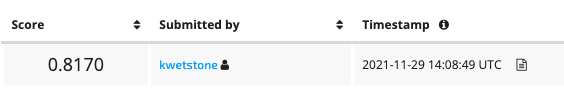

Our submission took about 20 minutes to execute. You can monitor progress during scoring with the Code Execution Status [tab](https://www.drivendata.org/competitions/83/submissions/code/). Finally, we see that we got an IOU of **0.817** - that's pretty good! It means that 81.7% of the area covered by either the ground truth labels or our predictions was shared between the two.

There is still plenty of room for improvement! Head over to the On Cloud N challenge [homepage](https://www.drivendata.org/competitions/83/cloud-cover/page/396/) to get started on your own model. We're excited to see what you create!